In [1]:
import torch
import torch.nn as nn        # Pytorch neural network package
import torch.optim as optim  # Pytorch optimization package
import torch.nn.functional as F
import numpy
import numpy as np
import matplotlib.pyplot as plt
from torchtyping import TensorType


device = torch.device("cuda")

In [2]:
likeDQN = "likeDQN" #likeDQN oder NotDQN

In [3]:


class Encoder(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 42 x 42
        self.conv2 = nn.Conv2d(32, 32, 2, 2, 1)  # 21 x 21
        self.conv3 = nn.Conv2d(32, 64, 2, 2, 1)  # 11 x 11
        self.conv4 = nn.Conv2d(64, 64, 2, 2, 1)  # 6 x 6
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(3136, 256) # 6x6x 64 = 2304
        self.BN1 = nn.BatchNorm1d(256)
        self.dense_means_logVar = nn.Linear(256, latent_dim*2)
        self.BN2 = nn.BatchNorm1d(latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print("conv1: " + str(h.size()))
        h = self.act(self.conv2(h))
        #print("conv2: " + str(h.size()))
        h = self.act(self.conv3(h))
        #print("conv3: " + str(h.size()))
        h = self.act(self.conv4(h))
        #print("conv4: " + str(h.size()))
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.BN1(self.dense1(h)))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var



In [4]:

class EncoderLikeDQN(nn.Module):
    def __init__(self, output_dim: int, num_channels: int, latent_dim: int):
        super(EncoderLikeDQN, self).__init__()
        self.output_dim = output_dim
        self.num_channels = num_channels

        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=8, stride=4, padding=0)  # 20 x 20
        self.conv2 = nn.Conv2d(32, 32, 4, 2, 1)  # 10 x 10
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)  # 10 x 10
        self.flat1 = nn.Flatten()        
        self.dense1 = nn.Linear(6400, 512) # 10x10x 64 = 6400
        self.BN1 = nn.BatchNorm1d(512)
        self.dense_means_logVar = nn.Linear(512, latent_dim*2)
        #self.dense_log_var = nn.Linear(256, latent_dim)

        self.act = nn.ReLU(inplace=True)
    
    
    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> (TensorType["batch", "output_dim"], TensorType["batch", "output_dim"]):
        #print("encoder: ")
        #print(x.size())
        h = self.act(self.conv1(x))
        #print(h.size())
        h = self.act(self.conv2(h))
        #print(h.size())
        h = self.act(self.conv3(h))
        #print(h.size())
        
        h = self.flat1(h)
        #print(h.size())
        h = self.act(self.BN1(self.dense1(h)))
        #print(h.size())
        #means = self.dense_means(h)
        #print(means.size())
        #log_var = self.dense_log_var(h)
        #print(log_var.size())
        return self.dense_means_logVar(h)
        
        #sample = self.reparameterize(means, log_var)
        
        #return sample, means, log_var
        #return means, log_var


In [5]:

class Decoder(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(Decoder, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 256)
        self.BN1 = nn.BatchNorm1d(256)
        self.dense2 = nn.Linear(256, 3136)
        self.BN2 = nn.BatchNorm1d(3136)


        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(32, 32, 2, stride=2, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, num_channels, 4, stride=2, padding=1)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("decoder: ")
        h = self.act(self.BN1(self.dense1(z)))
        h = self.act(self.BN2(self.dense2(h)))
        h = h.view(-1, 64, 7, 7)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print("Transpose 1: " + str(h.size()))
        h = self.act(self.upconv2(h))
        #print("Transpose 2: " + str(h.size()))
        h = self.act(self.upconv3(h))
        #print("Transpose 3: " + str(h.size()))
        img = self.upconv4(h)
        #print("Transpose 4: " + str(img.size()))
        return img



In [6]:

class DecoderLikeDQN(nn.Module):
    def __init__(self, input_dim: int, num_channels: int, latent_dim: int):
        super(DecoderLikeDQN, self).__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.dense1 = nn.Linear(latent_dim, 512)
        self.BN1 = nn.BatchNorm1d(512)
        self.dense2 = nn.Linear(512, 6400)
        self.BN2 = nn.BatchNorm1d(6400)        
        
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 32, 4, 2, 1)
        self.upconv3 = nn.ConvTranspose2d(32, num_channels, 8, 4, 0)

        self.act = nn.ReLU(inplace=True)
        

    def forward(self, z: TensorType["batch", "input_dim"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        #print("encoder: ")
        h = self.act(self.BN1(self.dense1(z)))
        h = self.act(self.BN2(self.dense2(h)))
        h = h.view(-1, 64, 10, 10)
        #print(h.size())
        h = self.act(self.upconv1(h))
        #print(h.size())
        h = self.act(self.upconv2(h))
        #print(h.size())
        img = self.upconv3(h)
        #print(img.size())
        return img


In [7]:
class VAE(nn.Module):
    def __init__(self, z_dim, num_channels, device, latent_dim):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.device = device
        if likeDQN == "likeDQN":
            self.encoder = EncoderLikeDQN(z_dim, num_channels, latent_dim) # use "wrong" encoder
            self.decoder = DecoderLikeDQN(z_dim, num_channels, latent_dim)
        elif likeDQN == "NotDQN":
            self.encoder = Encoder(z_dim, num_channels, latent_dim) # use "wrong" encoder
            self.decoder = Decoder(z_dim, num_channels, latent_dim)
        else:
            print("like DQN not correct!!")
            exit()

            
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
        self.mse = 0
        self.bce = 0
        self.tc = 0
        self.to(device)
        #self.rec_loss = nn.MSELoss() #try BCE Loss
        self.rec_loss = nn.BCELoss(reduction='sum') #() like that we have a high BCE loss maybe we can go higher with beta
        #self.rec_loss = nn.BCEWithLogitsLoss() #clamp input values betweeen 0 & 1 use without sigmoid after last output
        self.logsigmoid = nn.LogSigmoid()
        
        
    def gaussian_log_density(self, z_sampled: TensorType["batch", "num_latents"],
                         z_mean: TensorType["batch", "num_latents"],
                         z_logvar: TensorType["batch", "num_latents"]):
        normalization = torch.log(torch.tensor(2. * numpy.pi))
        inv_sigma = torch.exp(-z_logvar)
        tmp = (z_sampled - z_mean)
        return -0.5 * (tmp * tmp * inv_sigma + z_logvar + normalization)    

    def total_correlation(self, z: TensorType["batch", "num_latents"],
                      z_mean: TensorType["batch", "num_latents"],
                      z_logvar: TensorType["batch", "num_latents"]) -> torch.Tensor:
    
        batch_size = z.size(0)
        log_qz_prob = self.gaussian_log_density(z.unsqueeze(1), z_mean.unsqueeze(0), z_logvar.unsqueeze(0))

        log_qz_product = torch.sum(
            torch.logsumexp(log_qz_prob, dim=1),
            dim=1
        )
        log_qz = torch.logsumexp(
            torch.sum(log_qz_prob, dim=2),
            dim=1
        )
        return torch.sum(log_qz - log_qz_product)

    
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
       
        
    def num_channels(self):
        return self.encoder.num_channels

    def forward(self, x: TensorType["batch", "num_channels", "x", "y"]
                ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        if torch.isnan(z).any():
            print("z has NaN")
            print(z)
            # print("*************************************input saved***********")
            # x = x.cpu().detach().numpy()
            # numpy.save( "faulty_batch", x)

            
            
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        sigma = torch.exp(z[:, :, 1])
        reparam_z = mu + sigma*self.N.sample(mu.shape)
        self.kl = 0.5 * (sigma**2 + mu**2 - 2*torch.log(sigma) - 1).sum()
        self.tc = self.total_correlation(reparam_z, mu, logvar)
        
        x_t = self.decoder(reparam_z).sigmoid()
        #x_t = self.decoder(reparam_z) #No sigmoid if BCEWithLogitsLoss
        #x_t = self.logsigmoid(x_t) #funktioniert nicht wie gedacht!!

        #if torch.isnan(x_t).any():
            #print(x_t)
        #pred = x_t.clamp(0, 1) #push values between 0 and 1
        #pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred) #vlt muss das noch rein
        
        #self.mse = self.rec_loss(x_t, x)
        self.bce = self.rec_loss(x_t, x)
        return x_t
    
    # TODO: Passe diese Klasse noch an. Vlt geht damit das Kopieren zurück
    def encode(self, x: TensorType["batch", "num_channels", "x", "y"]
            ) -> TensorType["batch", "num_channels", "x", "y"]:
        z = self.encoder(x).view(x.size(0), self.z_dim, 2)
        mu = z[:, :, 0]
        logvar = z[:, :, 1]
        return (mu, logvar)
    
    #def decode(self, z: TensorType["batch", "num_latents"],
              #z_mean: TensorType["batch", "num_latents"],
              #z_logvar: TensorType["batch", "num_latents"]) -> torch.Tensor:
    
        #reparam_z = self.reparameterize(z_mean, z_logvar)
        #self.kl = 0.5 * (torch.exp(z_logvar)**2 + mu**2 - 2*z_logvar - 1).sum()
        #self.tc = self.total_correlation(reparam_z, z_mean, z_logvar)
        
        
    def decode(self, x: TensorType["batch", "y"]
              ) -> TensorType["batch", "y"]:
        
        return self.decoder(x).sigmoid()

In [8]:
#train_data = numpy.load('train_data100kFEB23.npy')
#val_data = numpy.load('val_data20kFEB23.npy')
val_data = numpy.load('val_data20kMAR22.npy')
valSquare= numpy.load('val_data20kWithLabelsMovingSQMETRICS.npz')['data']
valSquareLabels= numpy.load('val_data20kWithLabelsMovingSQMETRICS.npz')['labels']

In [9]:
#print(train_data.shape)

In [10]:
latentDim = 10
model = VAE(latentDim, 1, device, latentDim)
#model.load_state_dict(torch.load(r"C:\Users\erics\Documents\Programme\Bachelorarbeit\models\BTCVAE_Pong\ConvB1_TC2_Lat10_Epochs70VAE14-4SUM_SUM_SUM"))
#model.load_state_dict(torch.load(r"C:\Users\erics\Documents\Programme\Bachelorarbeit\models\BTCVAE_Pong\likeDQNConvB50_TC0_Lat10_Epochs100VAE27-4"))
model.load_state_dict(torch.load(r"C:\Users\erics\Documents\Programme\Bachelorarbeit\models\BTCVAE_Pong\likeDQNConvB10_TC0_Lat10_Epochs100VAE25-4"))
model.to(device)

VAE(
  (encoder): EncoderLikeDQN(
    (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flat1): Flatten(start_dim=1, end_dim=-1)
    (dense1): Linear(in_features=6400, out_features=512, bias=True)
    (BN1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense_means_logVar): Linear(in_features=512, out_features=20, bias=True)
    (act): ReLU(inplace=True)
  )
  (decoder): DecoderLikeDQN(
    (dense1): Linear(in_features=10, out_features=512, bias=True)
    (BN1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dense2): Linear(in_features=512, out_features=6400, bias=True)
    (BN2): BatchNorm1d(6400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (upconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), paddin

In [49]:
#randomInput = torch.rand(256, 1,84,84, device=device) #7056 = 84* 84
#randomInput = val_data[:256]
randomInput = valSquare[:256]
randomInput = np.expand_dims(randomInput, axis=1)
randomInput = torch.from_numpy(randomInput).to(device)
print(randomInput.size())


torch.Size([256, 1, 84, 84])


In [50]:
enco = model.encode(randomInput)
#print(enco)

In [51]:
def KLdiv(mu, logvar):
    print(mu.size())
    print((1 + logvar - mu.pow(2) - logvar.exp()).size())
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(KLD.size())
    return KLD

def compute_gaussian_kl(z_mean, z_logvar):
    return np.mean(0.5 * (np.square(z_mean) + np.exp(z_logvar) - z_logvar - 1), axis=0)

In [52]:
# get `mu` and `log_var`
mu = enco[0] # the first feature values as mean
log_var = enco[1]


KLenco = compute_gaussian_kl(mu.detach().cpu().numpy(), log_var.detach().cpu().numpy())
#print(KLenco.ndim)

#TODO: Wie macht man dimensionwise KL-divergence??

In [53]:
print(KLenco.shape)

(10,)


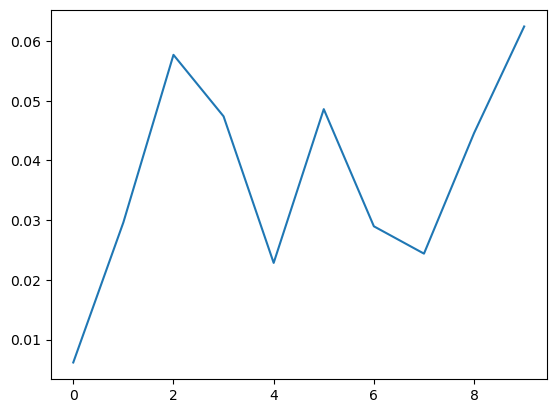

In [54]:
plt.plot(KLenco)
plt.show()

In [439]:
#KLencoMean = numpy.mean(KLenco, axis=0) # in kl_gaussian wird schon mean genommen

In [440]:
#plt.plot(KLencoMean)
#plt.show()

In [441]:
numZero = (numpy.histogram(KLenco, bins=(-0.5, 0.01))[0])#/2 #/2 da logvar & mean
print(numZero)

[0]


In [442]:
Nonzero = latentDim-numZero
print(Nonzero)

[10]


In [443]:
KLenco

array([0.01936742, 0.10878703, 0.03975812, 0.10329627, 0.03749277,
       0.09753335, 0.02594753, 0.02331597, 0.05093531, 0.06090254],
      dtype=float32)

Try latent spaces out


In [444]:
#model.eval()
#arr = torch.zeros([1, 10], dtype=torch.int32).to(device)
#arr[0, 5] = 1
#arr = arr.float()
#plt.imshow(model.decode(arr).detach().cpu().numpy()[0,0])
#plt.show()

<Figure size 4000x4000 with 0 Axes>

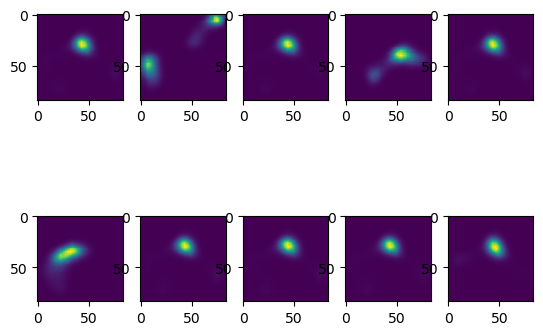

In [445]:
model.eval()

plt.figure(figsize = (40, 40))

f, axarr = plt.subplots(2,5) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(10):
    arr = torch.zeros([1, 10], dtype=torch.int32).to(device)
    arr[0, i] = 1
    arr = arr.float()
    plt.imshow(model.decode(arr).detach().cpu().numpy()[0,0])
    if i >4:
        axarr[1, i-5].imshow(model.decode(arr).detach().cpu().numpy()[0,0])
    else:
        axarr[0, i].imshow(model.decode(arr).detach().cpu().numpy()[0,0])
plt.show()

<Figure size 4000x4000 with 0 Axes>

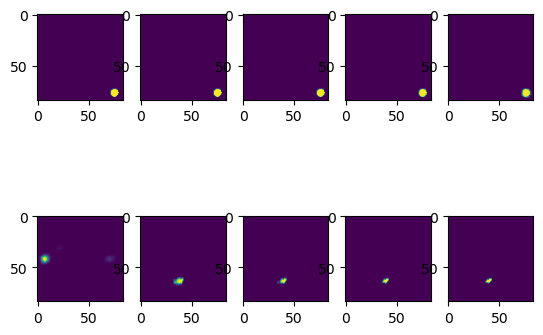

In [417]:
model.eval()

plt.figure(figsize = (40, 40))

f, axarr = plt.subplots(2,5) 
a = 0

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(-50, 50, 10):
    arr = torch.zeros([1, 10], dtype=torch.int32).to(device)
    arr[0, 4] = i
    arr = arr.float()
    plt.imshow(model.decode(arr).detach().cpu().numpy()[0,0])
    if a >4:
        axarr[1, a-5].imshow(model.decode(arr).detach().cpu().numpy()[0,0])
    else:
        axarr[0, a].imshow(model.decode(arr).detach().cpu().numpy()[0,0])
    a += 1
plt.show()

Plot the latent space
---

#beta = 50

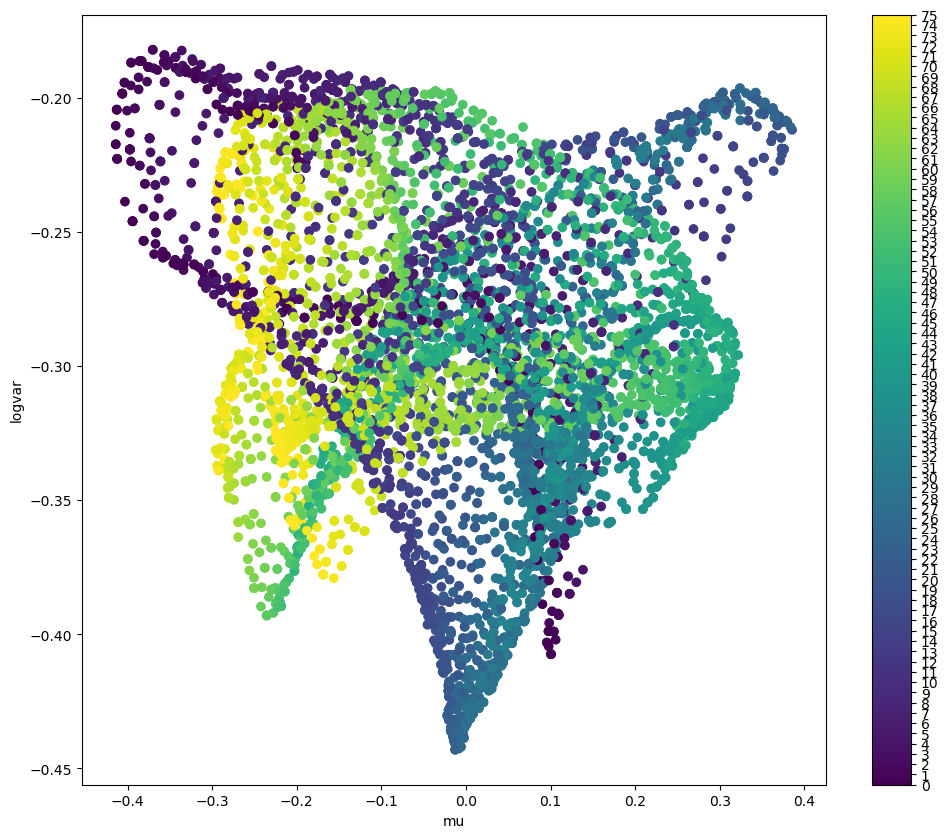

In [45]:
lat = 3
index = 10000

def plot_label_clusters(model, data, test_lab):
    mu, logvar = model.encode(data[:,None,:,:])
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(mu.detach().cpu().mean(axis=1), logvar.detach().cpu().mean(axis=1), c = test_lab)
    #sc = plt.scatter(mu[:,lat].detach().cpu(), logvar[:,lat].detach().cpu(), c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(84))
    cbar.ax.set_yticklabels([i for i in range(84)])
    plt.xlabel("mu")
    plt.ylabel("logvar")
    plt.show()
model.eval()
plot_label_clusters(model, torch.from_numpy(valSquare[:index]).to(device), valSquareLabels[:index][:,0])

beta = 10


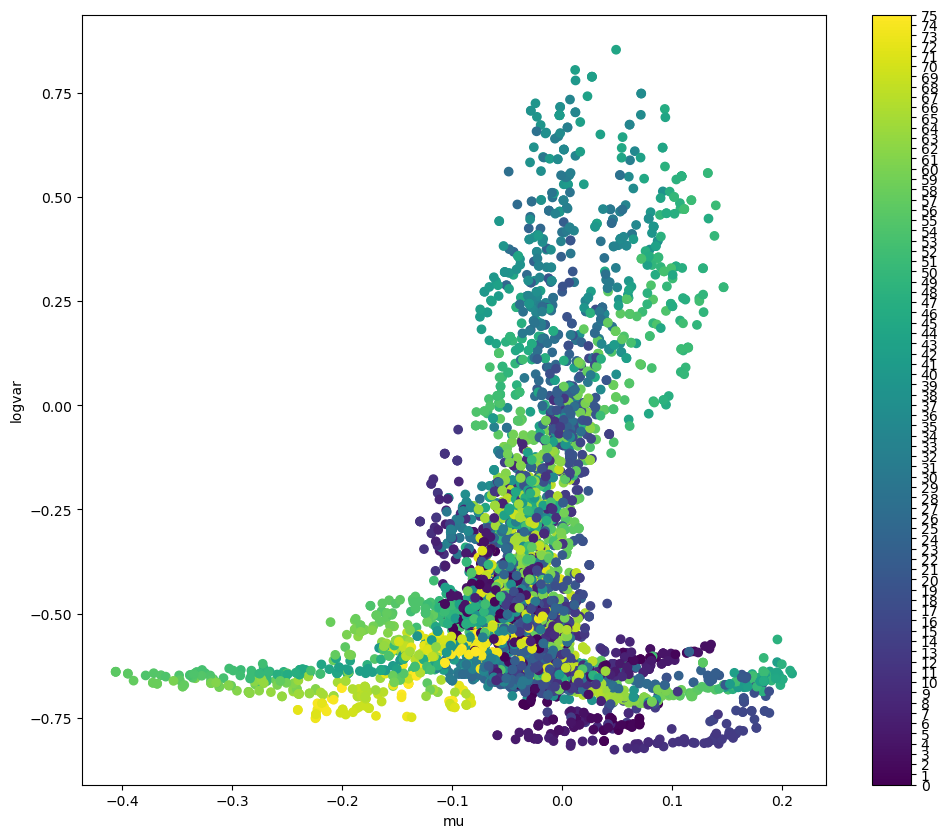

In [23]:
lat = 0
index = 5000

def plot_label_clusters(model, data, test_lab):
    mu, logvar = model.encode(data[:,None,:,:])
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(mu.detach().cpu().mean(axis=1), logvar.detach().cpu().mean(axis=1), c = test_lab)
    #sc = plt.scatter(mu[:,lat].detach().cpu(), logvar[:,lat].detach().cpu(), c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(84))
    cbar.ax.set_yticklabels([i for i in range(84)])
    plt.xlabel("mu")
    plt.ylabel("logvar")
    plt.show()
model.eval()
plot_label_clusters(model, torch.from_numpy(valSquare[:index]).to(device), valSquareLabels[:index][:,0])

In [27]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image
import os

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latentDim = 64
batch_size = 64
kl_wheight = 0.00064
beta = 3

if beta != 0 :
    tc_wheight = beta - 1
else: 
    tc_wheight = 0
beta = 1



In [28]:
newpath = f"C:/Users/erics/Documents/Programme/Bachelorarbeit/beat_VAE_Pong_runs/testConvTC{tc_wheight}_Beta{beta}Lat{latentDim}"
newpath = newpath + "/outputBetaMAR29"

if not os.path.exists(newpath):
    os.makedirs(newpath)
    
savingDir = newpath + "/epoch"

In [29]:
val_data = np.load('val_data20kFEB23.npy')

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
)

In [32]:
def validate(vae, dataloader):
    #enc.eval()
    #dec.eval()
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data = data.to(device)
            data = data[:, None, :, :]
            
          #  interData = enc(data)
          #  sample, mu, logvar = interData
          #  reconstruction = dec(sample)
                
          #  mse_loss = criterion(reconstruction, data)
          #  loss = final_loss(mse_loss, mu, logvar, beta, kl_wheight = dataloader.batch_size/len(val_data))
          #  running_loss += loss.item()
            reconstruction = vae(data)        
            loss = kl_wheight * beta * vae.kl + vae.bce + tc_wheight * vae.tc
            
            running_loss += loss.detach().cpu()
            
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 84, 84)[:8], 
                                  reconstruction.view(batch_size, 1, 84, 84)[:8]))
                save_image(both.cpu(), savingDir + f"0.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [33]:
validate(model, val_loader)

328it [00:29, 10.95it/s]                                                                                               


tensor(0.4699)